# Image Pipeline

### Imports and setup

In [1]:
import torchvision
import torch
import numpy
import glob
from PIL import Image
import os
from matplotlib import pyplot as plt

In [2]:
DATA_ROOT = "/data/liveproject-melanoma/MelanomaDetection"
UNLABELED_DATA_DIR = os.path.join(DATA_ROOT, 'unlabeled')
TRAINING_DATA_DIR = os.path.join(DATA_ROOT, 'labeled')
TEST_DATA_DIR = os.path.join(DATA_ROOT, 'test')

BATCH_SIZE = 20

### Custom Dataset classes

In [3]:
class CustomImageDataset(torch.utils.data.Dataset):
    FILE_PATTERN = '*.jpg'
    
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        self.file_paths = sorted(glob.glob(os.path.join(dir_path, UnlabeledDataset.FILE_PATTERN)))
        
    def __len__(self):
        return len(self.file_paths)
    
    def get_image_file_path(self, i):
        return self.file_paths[i]
    
    def get_image_and_transform(self, file_path):
        image = Image.open(file_path)
        
        if self.transform:
            return self.transform(image)
        
        return image

In [4]:
class UnlabeledDataset(CustomImageDataset):
    def __getitem__(self, i):
        return self.get_image_and_transform(self.get_image_file_path(i))

In [5]:
class LabeledDataset(CustomImageDataset):
    NEGATIVE_FILE_SUFFIX = '_0.jpg'
    POSITIVE_FILE_SUFFIX = '_1.jpg'
    
    def __get_label(self, file_path):
        if file_path.endswith(LabeledDataset.NEGATIVE_FILE_SUFFIX):
            return 0
        elif file_path.endswith(LabeledDataset.POSITIVE_FILE_SUFFIX):
            return 1
        else:
            raise ValueError
        
    def __getitem__(self, i):
        file_path = self.get_image_file_path(i)
        label = self.__get_label(file_path)
        return [self.get_image_and_transform(file_path), label]    

### Instantiate Datasets and DataLoaders

In [6]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

In [7]:
unlabeled_dataset = UnlabeledDataset(UNLABELED_DATA_DIR, transform=transform)
print(len(unlabeled_dataset))

7018


In [8]:
train_dataset = LabeledDataset(TRAINING_DATA_DIR, transform=transform)
print(len(train_dataset))

200


In [9]:
test_dataset = LabeledDataset(TEST_DATA_DIR, transform=transform)
print(len(test_dataset))

600


In [10]:
unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Show samples

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_batch(batch):
    
    def numpy_transpose(sample):
        return numpy.transpose(sample, (1, 2, 0))
    
    labeled = len(batch) == 2
    num_samples = len(batch[0]) if labeled else len(batch)
    
    fig = plt.figure(figsize=(num_samples, num_samples))
    grid = ImageGrid(
        fig, 
        111,  # similar to subplot(111)
        nrows_ncols=(1, num_samples),
        axes_pad=0.1,  # pad between axes in inch.
    )
    
    if labeled:
        samples, labels = batch
        for ax, sample, label in zip(grid, samples, labels):
            ax.set_title(label.item())
            ax.axis('off')
            ax.imshow(numpy_transpose(sample))
            
    else:
        for ax, sample in zip(grid, batch):
            ax.axis('off')
            ax.imshow(numpy_transpose(sample))
    
    plt.show()

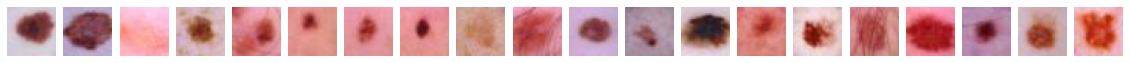

In [12]:
show_batch(next(iter(unlabeled_dataloader)))

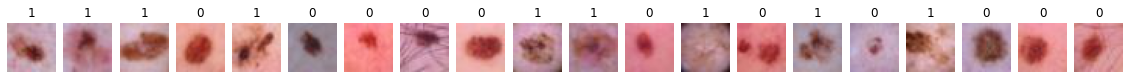

In [13]:
show_batch(next(iter(train_dataloader)))

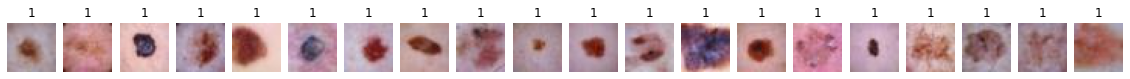

In [14]:
show_batch(next(iter(test_dataloader)))

### Preprocessing, Data Augmentation

> After looking at the images, what transformations do you propose to use for the pre-processing and the data augmentation?

#### Preprocessing

* To tensor
* Normalization?

#### Data Augmentation

* Rotation by 90, 180, 270 degrees
* Vertical, Horizontal mirroring
* Scaling slightly
* Slight variation in image saturation, brightness, contrast?
* Offsetting (problem: how to fill up missing pixels?)